In [249]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
def seed_everything(seed=2020):
    random.seed(seed)
    np.random.seed(seed)
seed_everything(42)

warnings.filterwarnings("ignore")
%matplotlib inline

# Pulsar star

In [250]:
data = pd.read_csv("../../data/pulsar_stars.csv")
data.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [251]:
data.shape

(17898, 9)

In [252]:
data.columns = data.columns.str.strip()
data.columns = ['IP Mean', 'IP Sd', 'IP Kurtosis', 'IP Skewness', 
              'DM-SNR Mean', 'DM-SNR Sd', 'DM-SNR Kurtosis', 'DM-SNR Skewness', 'target_class']

In [253]:
# data['target_class'].value_counts()
# view the percentage distribution of target_class column
data['target_class'].value_counts()/np.float(len(data))

0    0.908426
1    0.091574
Name: target_class, dtype: float64

In [254]:
df_ab = data[data['target_class']==1]
df_nnorm = data[data['target_class']!=1]
df_ab.head()

,IP Mean,IP Sd,IP Kurtosis,IP Skewness,DM-SNR Mean,DM-SNR Sd,DM-SNR Kurtosis,DM-SNR Skewness,target_class
19,99.367188,41.572202,1.547197,4.154106,27.555184,61.719016,2.208808,3.662680,1
42,120.554688,45.549905,0.282924,0.419909,1.358696,13.079034,13.312141,212.597029,1
61,27.765625,28.666042,5.770087,37.419009,73.112876,62.070220,1.268206,1.082920,1
92,23.625000,29.948654,5.688038,35.987172,146.568562,82.394624,-0.274902,-1.121848,1
93,94.585938,35.779823,1.187309,3.687469,6.071070,29.760400,5.318767,28.698048,1


In [255]:
from sklearn.preprocessing import MinMaxScaler

scaler    = MinMaxScaler()
df_values = df_ab.copy()
column_list = list(df_values.columns) 
df_values = df_values.drop(['target_class'], axis=1)
df_norm   = scaler.fit_transform(df_values)

In [256]:
# X = df_norm.drop(['target_class'],axis=1)
# y= df_norm['target_class']

In [257]:
column_list

['IP Mean',
 'IP Sd',
 'IP Kurtosis',
 'IP Skewness',
 'DM-SNR Mean',
 'DM-SNR Sd',
 'DM-SNR Kurtosis',
 'DM-SNR Skewness',
 'target_class']

In [258]:
df_norm.shape[1]

8

# Autoencoder

In [259]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler

from keras.models import Sequential, Model
from keras.layers import Dense, BatchNormalization, Dropout, Flatten, Input
from keras import backend as K
import keras
from matplotlib.colors import LogNorm

In [260]:
n_features = df_norm.shape[1]

dim = 15

def build_model(dropout_rate=0.15, activation='tanh'):
    main_input = Input(shape=(n_features, ), name='main_input')
    
    x = Dense(dim*2, activation=activation)(main_input)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    x = Dense(dim*2, activation=activation)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate/2)(x)
    
    x = Dense(dim, activation=activation)(x)
    x = Dropout(dropout_rate/4)(x)

    encoded = Dense(n_features, activation='tanh')(x)

    input_encoded = Input(shape=(n_features, ))
    
    x = Dense(dim, activation=activation)(input_encoded)
    x = Dense(dim, activation=activation)(x)
    x = Dense(dim*2, activation=activation)(x)
    
    decoded = x = Dense(n_features, activation='linear')(x)

    encoder = Model(main_input, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(main_input, decoder(encoder(main_input)), name="autoencoder")
    return encoder, decoder, autoencoder

K.clear_session()
c_encoder, c_decoder, c_autoencoder = build_model()
c_autoencoder.compile(optimizer='nadam', loss='mse')

c_autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 8)]               0         
_________________________________________________________________
encoder (Functional)         (None, 8)                 2033      
_________________________________________________________________
decoder (Functional)         (None, 8)                 1103      
Total params: 3,136
Trainable params: 3,016
Non-trainable params: 120
_________________________________________________________________


Epoch 1/50
1/1 [==============================] - 0s 997us/step - loss: 0.2028
Epoch 2/50
1/1 [==============================] - 0s 2ms/step - loss: 0.1843
Epoch 3/50
1/1 [==============================] - 0s 996us/step - loss: 0.1747
Epoch 4/50
1/1 [==============================] - 0s 997us/step - loss: 0.1647
Epoch 5/50
1/1 [==============================] - 0s 997us/step - loss: 0.1544
Epoch 6/50
1/1 [==============================] - 0s 2ms/step - loss: 0.1477
Epoch 7/50
1/1 [==============================] - 0s 997us/step - loss: 0.1409
Epoch 8/50
1/1 [==============================] - 0s 2ms/step - loss: 0.1327
Epoch 9/50
1/1 [==============================] - 0s 998us/step - loss: 0.1281
Epoch 10/50
1/1 [==============================] - 0s 997us/step - loss: 0.1213
Epoch 11/50
1/1 [==============================] - 0s 2ms/step - loss: 0.1143
Epoch 12/50
1/1 [==============================] - 0s 2ms/step - loss: 0.1089
Epoch 13/50
1/1 [==============================] - 0s 2ms/s

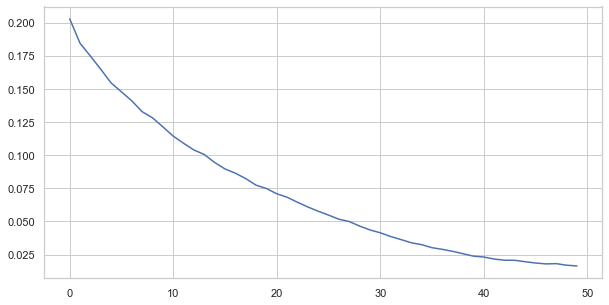

In [261]:
%%time
epochs = 50
batch_size = 9548
history = c_autoencoder.fit(df_norm, df_norm,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    verbose=1)

loss_history = history.history['loss']
plt.figure(figsize=(10, 5))
plt.plot(loss_history);

In [262]:
ae = c_encoder.predict(df_norm)
ae.shape

(1639, 8)

In [263]:
ae

array([[ 0.06456414, -0.22654045,  0.44067445, ...,  0.45008942,
        -0.6465067 ,  0.19120792],
       [-0.46060544, -0.48210588, -0.04445555, ..., -0.13344504,
        -0.80290115, -0.22967227],
       [ 0.5705468 ,  0.23063456,  0.59266543, ...,  0.76321137,
        -0.17090225,  0.5622076 ],
       ...,
       [ 0.17618644, -0.16123074,  0.47505984, ...,  0.5418811 ,
        -0.5811845 ,  0.23836221],
       [ 0.6731156 ,  0.1589625 ,  0.64106613, ...,  0.83328795,
        -0.11206245,  0.5885707 ],
       [ 0.39032328, -0.34716615,  0.6020679 , ...,  0.63483083,
        -0.5365683 ,  0.23466964]], dtype=float32)

In [264]:
df_ae = pd.DataFrame(ae)
df_ae['target_class'] = 1

In [265]:
df_ae.columns = column_list
df_ae.head(10)

,IP Mean,IP Sd,IP Kurtosis,IP Skewness,DM-SNR Mean,DM-SNR Sd,DM-SNR Kurtosis,DM-SNR Skewness,target_class
0,0.064564,-0.226540,0.440674,0.296152,-0.146111,0.450089,-0.646507,0.191208,1
1,-0.460605,-0.482106,-0.044456,-0.030477,0.026928,-0.133445,-0.802901,-0.229672,1
2,0.570547,0.230635,0.592665,0.424914,-0.281114,0.763211,-0.170902,0.562208,1
3,0.658227,0.089716,0.639037,0.530417,-0.042873,0.824736,-0.169206,0.531113,1
4,-0.163046,-0.289179,0.163445,0.063292,-0.104822,0.143348,-0.694971,0.013132,1
5,-0.041339,-0.351463,0.403973,0.301041,-0.076857,0.353219,-0.707260,0.132404,1
6,0.401294,0.157874,0.547130,0.331557,-0.313049,0.687172,-0.338079,0.438132,1
7,0.571004,0.348397,0.626869,0.406886,-0.417797,0.769957,-0.084886,0.619709,1
8,0.542711,-0.242764,0.540207,0.537756,0.323893,0.690531,-0.363073,0.354725,1
9,0.654890,-0.053482,0.633807,0.560789,0.175413,0.802957,-0.231916,0.454206,1


In [266]:
df_nvalues = data.drop(['target_class'], axis=1)
scaled_nnorm   = scaler.fit_transform(df_nvalues)
df_scaler_nnorm = pd.DataFrame(scaled_nnorm, index=df_nvalues.index, columns=df_nvalues.columns)
df_scaler_nnorm['target_class'] = data.target_class
df_scaler_nnorm.head()

,IP Mean,IP Sd,IP Kurtosis,IP Skewness,DM-SNR Mean,DM-SNR Sd,DM-SNR Kurtosis,DM-SNR Skewness,target_class
0,0.721342,0.417687,0.165043,0.015627,0.013382,0.113681,0.294986,0.063890,0
1,0.517628,0.460908,0.235415,0.018268,0.006560,0.072524,0.364015,0.108443,0
2,0.520346,0.196868,0.221138,0.040677,0.013030,0.139188,0.288624,0.054610,0
3,0.700933,0.437884,0.181750,0.016534,0.015368,0.131583,0.266348,0.046581,0
4,0.443854,0.214847,0.249044,0.041712,0.004327,0.039684,0.462029,0.213369,0


In [275]:
df_train = pd.concat([df_ae, df_scaler_nnorm], ignore_index=True)
df_train.shape

(19537, 9)

In [268]:
X = df_train.drop(['target_class'], axis=1)
y = df_train['target_class']

In [269]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [270]:
# Model

In [271]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import matthews_corrcoef, confusion_matrix,precision_recall_curve,auc,f1_score,roc_auc_score,roc_curve,recall_score,classification_report 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


In [272]:

def model(algorithm,dtrain_x,dtrain_y,dtest_x,dtest_y):
    
    print ("MODEL - OUTPUT")
    print ("*****************************************************************************************")
    algorithm.fit(dtrain_x,dtrain_y)
    predictions = algorithm.predict(dtest_x)
    
    print (algorithm)
    print ("\naccuracy_score :",accuracy_score(dtest_y,predictions))
    print ("\nrecall score:\n",(recall_score(dtest_y,predictions)))
    print ("\nf1 score:\n",(f1_score(dtest_y,predictions)))
#     print ("\nclassification report :\n",(classification_report(dtest_y,predictions)))
    print ("\nmatthews_corrcoef:\n", (matthews_corrcoef(dtest_y, predictions)))
    #cross validation
    
    # Graph
    plt.figure(figsize=(13,10))
    plt.subplot(221)
    sns.heatmap(confusion_matrix(dtest_y,predictions),annot=True,fmt = "d",linecolor="k",linewidths=3)
    plt.title("CONFUSION MATRIX",fontsize=20)
    
    predicting_probabilites = algorithm.predict_proba(dtest_x)[:,1]
    fpr,tpr,thresholds = roc_curve(dtest_y,predicting_probabilites)
    plt.subplot(222)
    plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
    plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
    plt.legend(loc = "best")
    plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)


MODEL - OUTPUT
*****************************************************************************************
DecisionTreeClassifier()

accuracy_score : 0.9696349368816104

recall score:
 0.9197080291970803

f1 score:
 0.9083419155509783

matthews_corrcoef:
 0.8902462143599278


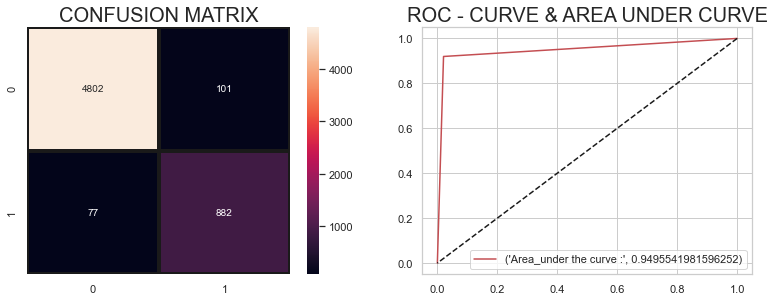

In [273]:
clf = DecisionTreeClassifier()
model(clf ,X_train,y_train,X_test,y_test)

MODEL - OUTPUT
*****************************************************************************************
SVC(probability=True)

accuracy_score : 0.981064483111566

recall score:
 0.9155370177267987

f1 score:
 0.9405463310123192

matthews_corrcoef:
 0.9297860395364231


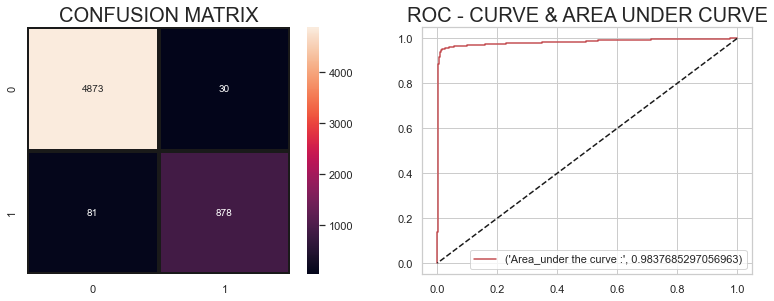

In [274]:
svc=SVC(probability=True) 

model(svc ,X_train,y_train,X_test,y_test)